In [18]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl

In [19]:
from train import CoarseNetTraining
from data.nyu import NYU

In [20]:
train_data = NYU('D:\\Jupyter_D\\VKR\\nyudepthv2', 'D:\\Jupyter_D\\VKR\\NLSPN_ECCV20-master\\data_json\\nyu.json', 
           True, 25000, 'train', coarse=True,  coarse_height=200)
val_data = NYU('D:\\Jupyter_D\\VKR\\nyudepthv2', 'D:\\Jupyter_D\\VKR\\NLSPN_ECCV20-master\\data_json\\nyu.json', 
           False, 25000, 'val', coarse=True,  coarse_height=200)
val_data_500 = NYU('D:\\Jupyter_D\\VKR\\nyudepthv2', 'D:\\Jupyter_D\\VKR\\NLSPN_ECCV20-master\\data_json\\nyu.json', 
           False, 500, 'val', coarse=True,  coarse_height=200)

train_loader = DataLoader(train_data, batch_size=16, shuffle=False)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
val_loader_1 = DataLoader(val_data, batch_size=1, shuffle=False)

In [21]:
task = CoarseNetTraining(128, 64, train_data[0]['dep'].shape[1:])
task.model.load_state_dict(torch.load('CoarseNet_l1_trained'))
#task.cuda()

<All keys matched successfully>

task.load_from_checkpoint('lightning_logs/version_30/checkpoints/epoch=4-step=7064.ckpt',
                         token_channels=128, token_hidden=64, image_shape=train_data[0]['dep'].shape[1:])

In [5]:
trainer = pl.Trainer(gpus=1, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [6]:
trainer.fit(task, train_loader, val_loader_1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | CoarseNet    | 12.3 M
1 | loss  | MaskedL1Loss | 0     
---------------------------------------
12.3 M    Trainable params
0         Non-trainable params
12.3 M    Total params
49.050    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [17]:
torch.save(task.model.state_dict(), 'CoarseNet_l1_trained_2')

7 эпох учить минимум

Обучил пол эпохи, рмсе: 

In [8]:
trainer.validate(task, val_loader_1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 0.14446023106575012,
 'val_rel': 0.03385772928595543,
 'val_rmse': 0.195958212018013}
--------------------------------------------------------------------------------


[{'val_loss': 0.14446023106575012,
  'val_rmse': 0.195958212018013,
  'val_rel': 0.03385772928595543}]

In [11]:
def parse_dataset(model, dataset, image):
    rgb_origin, dep_origin, gt_origin = dataset[image]['rgb'], dataset[image]['dep'], dataset[image]['gt']
    rgb, dep, gt = rgb_origin.resize(1, 3, 200, 200), dep_origin.resize(1, 1, 200, 200), gt_origin.resize(1, 1, 200, 200)
    mask = (dep > 0).float()
    inpainted_dep = model(rgb, dep, mask)
    inpainted_dep[dep > 0] = dep[dep > 0] 
    return { 'rgb': rgb_origin.transpose(0, 2).transpose(0,1), 
            'dep': dep_origin.resize(200, 200), 
            'gt': gt_origin.resize(200, 200),
             'Ours': inpainted_dep[0, 0].detach().numpy()}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


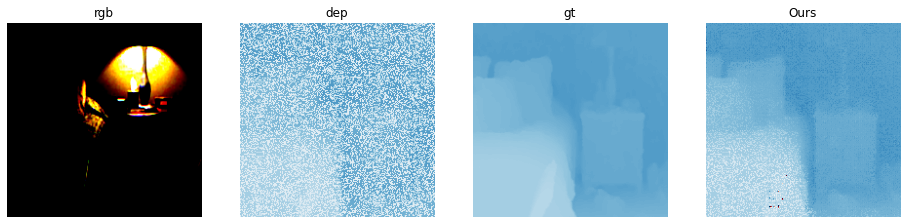

In [17]:
image = 15
fig, axes = plt.subplots(1, 4, figsize=(16,10))
images = parse_dataset(task.model, val_data, image)

vmin = -18.991743 #min(images['gt'].min(), images['inpainted_dep'].min())
vmax = 23.386961 #max(images['gt'].max(), images['inpainted_dep'].max())

for ax,im in zip(axes, images):
    ax.axis('off')
    ax.set_title(im)
    if im == 'rgb':
        ax.imshow(images[im])
    else:
        ax.imshow(images[im]*-2, cmap='RdBu_r', vmin=vmin, vmax=vmax)